## Force-Directed-Layout

Generate the force directed layout representation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import igraph as ig
import random
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300
L = 15
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']


In [4]:
df = pd.read_csv(f"../../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")


reps = set([a.split("_")[-1] 
            for a in df.keys() 
            if a.startswith("mean_log10PE")])
concs = set([int(a.split("_")[1][7:])
            for a in df.keys() 
            if a.startswith("mean_log10PE")])            
for aa in reps:
    for ii in concs:
        df = df.rename({f"mean_log10PE{ii}_{aa}": f"mean_log10PE{ii}_{aa}_ACE2",
                   f"std_log10PE{ii}_{aa}":f"std_log10PE{ii}_{aa}_ACE2"}, axis=1) 

df["variant_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
    
df["expression_norm_b"] = df['Mean fluorescence expression_b']/df['Mean fluorescence expression_b'].mean()
df["expression_norm_a"] = df['Mean fluorescence expression_a']/df['Mean fluorescence expression_a'].mean()
df["expression_norm"] = 1/2*(df["expression_norm_a"] + df["expression_norm_b"])

In [73]:
#### FOR TESTING LAYOUT ####
# shorter dataframe for easy initial testing
L = 10
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))
df = df[df.variant_int < 2**L].copy()
df["geno"] = df["geno"].apply(lambda x: x[:8])
df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
############################


In [12]:
# read data into graph


fitnesses = {}
fitnesses["ACE2"] = (df.set_index("variant_int")["log10Kd"]).to_dict()

g = ig.Graph()
vertices = [s for s in sequences_int if ~np.isnan(fitnesses["ACE2"][s])]
g.add_vertices([str(s) for s in vertices])
g.add_edges([(str(s),str(t)) for s in vertices for t in reachable(s, L) if t in vertices])


#### weight choices ####
# high weight means very close nodes on the graph.
weight_strength = 1
min_difference = 1e-2
g.es["weight"] = [weight_strength/(min_difference 
                                   + np.nanmean([
                                       np.abs(fitnesses[solu][t] - fitnesses[solu][s])
                                       for solu in fitnesses
                                         ])
                                   ) # weight
                            for s in vertices
                            for t in reachable(s, L) if t in vertices]
########################

g.vs["endpoints"] = [(s == 0 or s == len(sequences_int)-1) for s in sequences_int]



In [13]:
# draw the layout

# generate seed
random.seed(42) 
seed = np.empty((len(vertices),2))
for i in range(len(vertices)):
    xcoord = random.uniform(-100,100)
    ycoord = random.uniform(-100,100)
    seed[i,:] = [xcoord,ycoord]
    
# create layout
layout = g.layout_drl(weights='weight',seed=seed)

# update df
coord =  np.array(layout.coords)
#print(coord)
xcoord = {vertices[i]:-1.0*coord[i, 1] for i in range(len(vertices))}
ycoord = {vertices[i]:coord[i, 0] for i in range(len(vertices))}
df["fdl_x"] = df.variant_int.map(xcoord)
df["fdl_y"] = df.variant_int.map(ycoord)



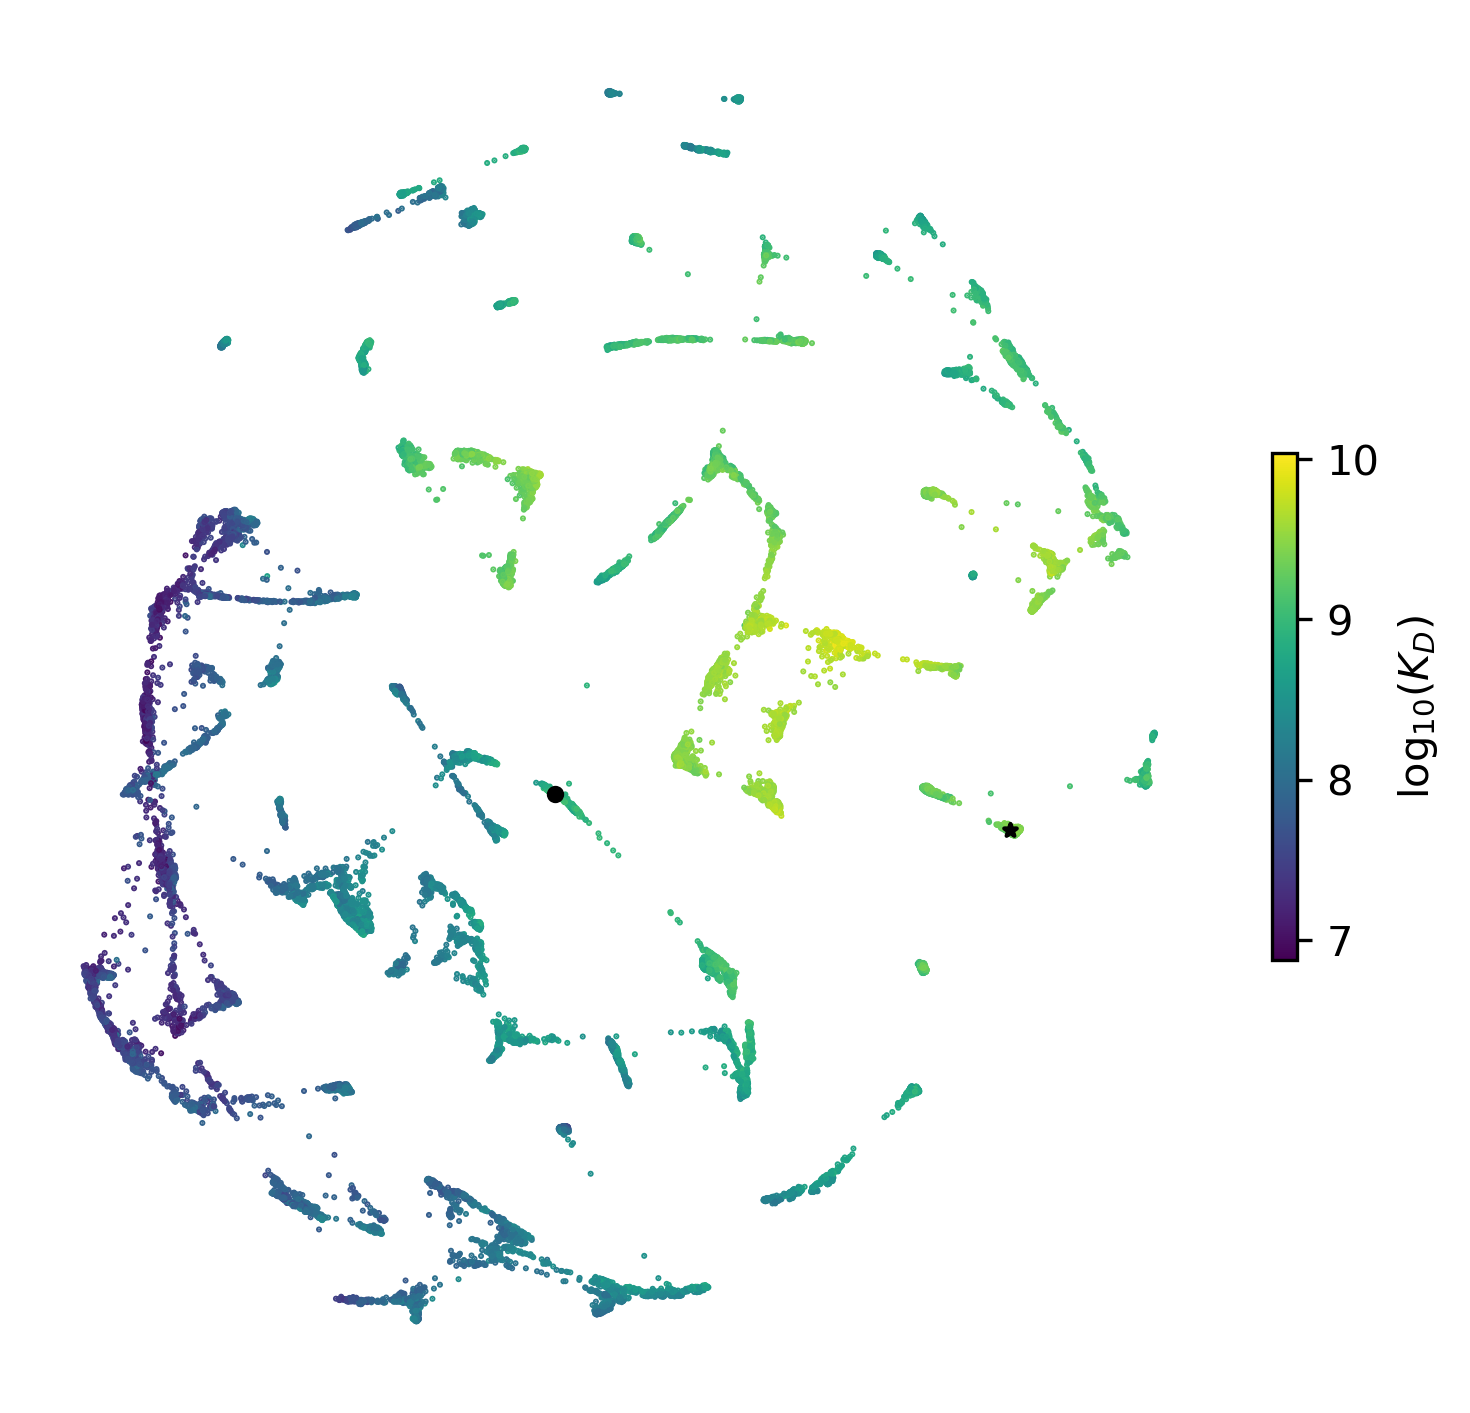

In [42]:
fig, ax = plt.subplots(figsize=(5,5))
sc = ax.scatter(x=df.fdl_x, y=df.fdl_y,
           s=0.2, c=df.log10Kd, alpha=1)
plt.colorbar(sc,fraction=0.02,label=r"$\log_{10}(K_D)$")

ax.scatter(x=df[df.geno == "0"*L].fdl_x, y=df[df.geno == "0"*L].fdl_y,
           s=10, c='black', alpha=1, marker="o")
ax.scatter(x=df[df.geno == "1"*L].fdl_x, y=df[df.geno == "1"*L].fdl_y,
           s=10, c="black", alpha=1, marker="*")
ax.set_aspect('equal')
ax.set_axis_off()
plt.tight_layout()
plt.savefig("../Figures/SI_FDL_A.png")
plt.show()

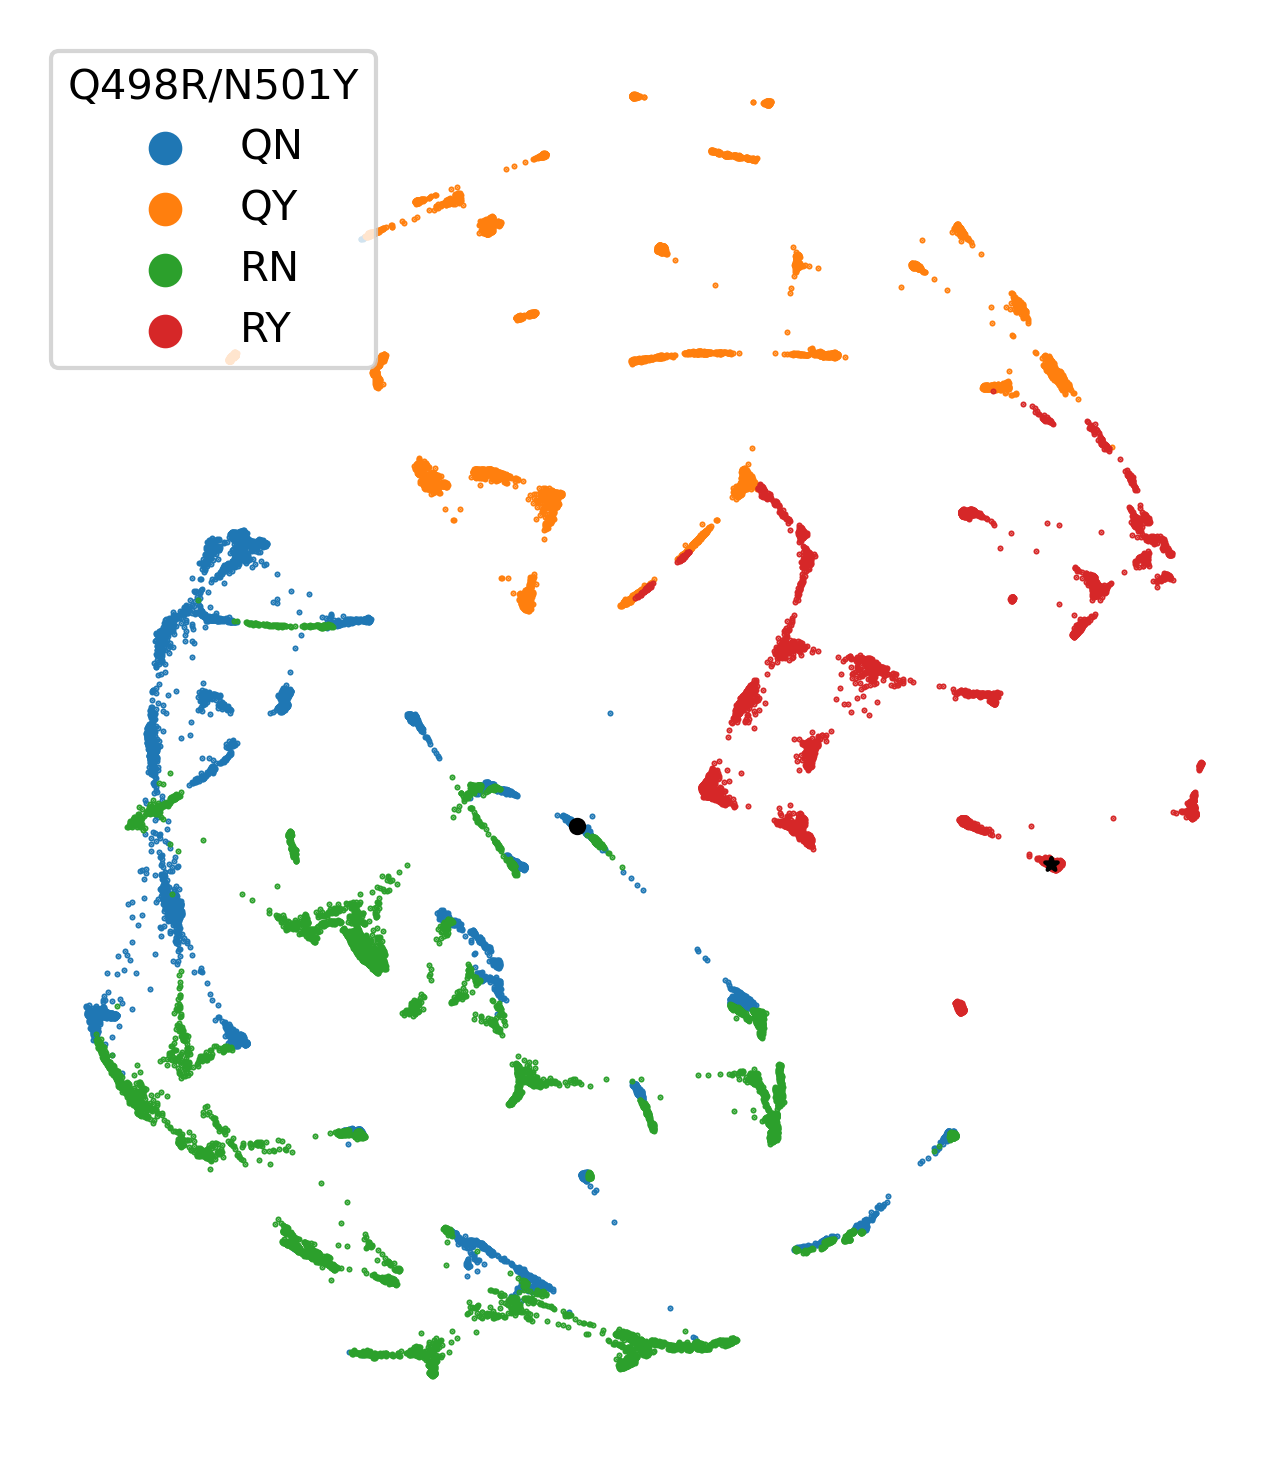

In [43]:
df["Q498R/N501Y"] = df.geno.str[12:14].map({"00": "QN", "01":"QY", "10": "RN", "11":"RY"})
fig, ax = plt.subplots(figsize=(5,5))

for ii, c in enumerate(df["Q498R/N501Y"].unique()):
    ax.scatter(x=df[df["Q498R/N501Y"] == c].fdl_x, y=df[df["Q498R/N501Y"] == c].fdl_y,
               s=0.2, color=sns.color_palette()[ii], alpha=1, label=c)

ax.scatter(x=df[df.geno == "0"*L].fdl_x, y=df[df.geno == "0"*L].fdl_y,
           s=10, c='black', alpha=1, marker="o")
ax.scatter(x=df[df.geno == "1"*L].fdl_x, y=df[df.geno == "1"*L].fdl_y,
           s=10, c="black", alpha=1, marker="*")
ax.set_aspect('equal')
ax.set_axis_off()
lg = plt.legend(title="Q498R/N501Y")
for g in lg.legendHandles:
    g._sizes = [50]
plt.tight_layout()
plt.savefig("../Figures/SI_FDL_B.png")
plt.show()